# Tidy Tuesday in Python: 2019-02-19 - US Phds

This analysis is a python translation of Dave Robinson's R [code](https://github.com/dgrtwo/data-screencasts/blob/master/us_phds.Rmd) and corresponding [screencast](https://youtu.be/KzRP40PzopY).

It compares the code for these python approaches side-by-side:

* [siuba](http://github.com/machow/siuba) 
* [pandas](https://github.com/pandas-dev/pandas)

In [1]:
import pandas as pd
import numpy as np

from qgrid import show_grid

from siuba import *
from plotnine import *

## Preprocessing

In [2]:
major_fields_raw = pd.read_excel(
    "./data/sed17-sr-tab012.xlsx",
    skiprows = 3
)

In [3]:
renamed = rename(major_fields_raw, field = "Field of study")

melted_majors = renamed.melt(id_vars = "field", var_name = "key")

major_fields = (
    melted_majors
    >> mutate(
        year=_.key.replace("Unnamed", np.nan, regex = True),
        type=_.value.where(_.value.str.contains("Number|Percent"), np.nan),
        value=lambda d: pd.to_numeric(d.value, "coerce")
    )
    >> mutate(year=_.year.ffill(), type=_.type.ffill())
    >> select(-_.key)
    >> filter(_.value.notna())
    >> spread(_.type, _.value)
)

major_fields

,field,year,Number,Percent
0,"Aerospace, aeronautical, and astronautical eng...",1987,142.0,0.4
1,"Aerospace, aeronautical, and astronautical eng...",1992,234.0,0.6
2,"Aerospace, aeronautical, and astronautical eng...",1997,273.0,0.6
3,"Aerospace, aeronautical, and astronautical eng...",2002,209.0,0.5
4,"Aerospace, aeronautical, and astronautical eng...",2007,267.0,0.6
...,...,...,...,...
310,Unknown field,1997,1.0,NaN
311,Unknown field,2002,0.0,0.0
312,Unknown field,2007,3.0,NaN
313,Unknown field,2012,0.0,0.0


## Plotting degrees over time for 6 degrees

In [19]:
fine_fields = (
    pd.read_excel("./data/sed17-sr-tab013.xlsx", skiprows=3)
    >> rename(field = "Fine field of study")
    >> gather("year", "number", -_.field)
    >> filter(_.number != 'na')
    >> mutate(
        field = _.field.str.strip(),
        year = _.year.astype(float), 
        number = _.number.astype(float)        
    )
)

fine_fields

,field,year,number
0,All fields,2008.0,48777.0
1,Life sciences,2008.0,11086.0
2,Agricultural sciences and natural resources,2008.0,1198.0
3,Agricultural economics,2008.0,111.0
4,Agricultural and horticultural plant breeding,2008.0,28.0
...,...,...,...
3825,"Parks, sports, recreation, leisure and fitness",2017.0,49.0
3826,Public administration,2017.0,185.0
3827,Social work,2017.0,298.0
3828,Other fields nec,2017.0,103.0


In [5]:
# investigated why a space was there
ceramics = fine_fields >> filter(_.field.str.startswith("Ceramic"))
ceramics.values[0]



array(['Ceramic sciences engineering', 2008.0, 7.0], dtype=object)

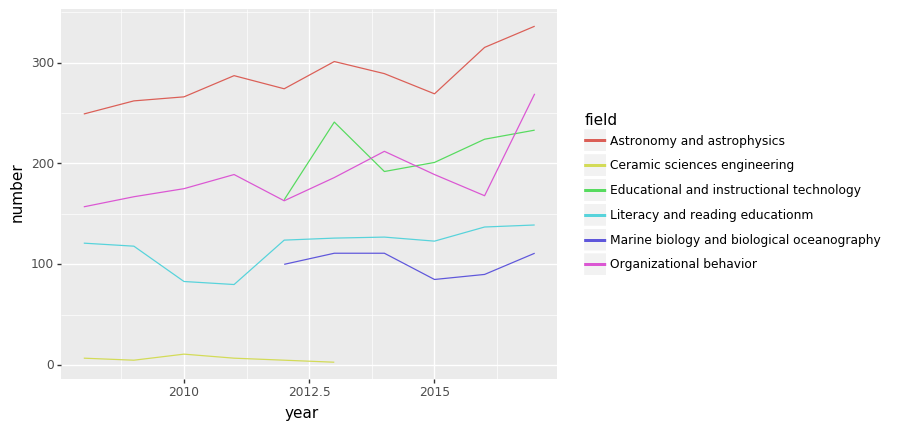

<ggplot: (-9223372036560744269)>

In [6]:
from random import sample

#field_subset = sample(list(fine_fields.field.unique()), 6)

field_subset = ['Marine biology and biological oceanography',
 'Educational and instructional technology',
 'Astronomy and astrophysics',
 'Organizational behavior',
 'Literacy and reading educationm',
 'Ceramic sciences engineering']

(
    fine_fields
    >> filter(_.field.isin(field_subset))
    >> ggplot(aes("year", "number", color="field"))
     + geom_line()
)

In [7]:
sex = ["All", "Male", "Female", "All doctorate recipientsa", "All fieldsa"]

broad_fields_raw = pd.read_excel("./data/sed17-sr-tab014.xlsx", skiprows=4)

broad_fields_formatted = (
    broad_fields_raw
    >> rename(field="Unnamed: 0")
    >> filter(~_.field.isin(sex))
    >> mutate(
        field=_.field.rename({
            "Life sciencesb": "Life sciences",
            "Otherc": "Other"
        })
    )
)

broad_fields = broad_fields_formatted.field

broad_fields

3                            Life sciences
6     Physical sciences and earth sciences
9        Mathematics and computer sciences
12          Psychology and social sciences
15                             Engineering
18                               Education
21                     Humanities and arts
24                                   Other
Name: field, dtype: object

In [8]:
recipients_year_field_sex_raw = pd.read_excel("./data/sed17-sr-tab015.xlsx", skiprows=3)
recipients_year_field_sex_raw.columns = recipients_year_field_sex_raw.columns.map(str)


recipients_year_field_sex = (
    recipients_year_field_sex_raw
    >> rename(field="Sex and major field of study")
    >> select(-_.contains("change"))
    >> mutate(
        field=_.field.replace({
            "All doctorate recipientsa": "All",
            "Otherb": "Other"
            }),
        sex=_.field.where(_.field.isin(["Male", "Female", "All"])),
        broad_field= _.field.where(_.field.isin(broad_fields))
    )
    >> mutate(sex = _.sex.ffill(), broad_field = _.broad_field.ffill())
    >> gather("year", "number", -_.sex, -_.broad_field, -_.field)
    >> filter(~_.field.isin(sex), _.number.notna())
    >> mutate(year = _.year.astype(int))
)

recipients_year_field_sex

,field,sex,broad_field,year,number
1,Life sciences,All,Life sciences,2008,11086
2,Agricultural sciences and natural resources,All,Life sciences,2008,1198
3,Biological and biomedical sciences,All,Life sciences,2008,7797
4,Health sciences,All,Life sciences,2008,2091
5,Physical sciences and earth sciences,All,Physical sciences and earth sciences,2008,4946
...,...,...,...,...,...
1345,Other,Female,Other,2017,1713
1346,Business management and administration,Female,Other,2017,675
1347,Communication,Female,Other,2017,428
1348,Non-S&E fields nec,Female,Other,2017,610


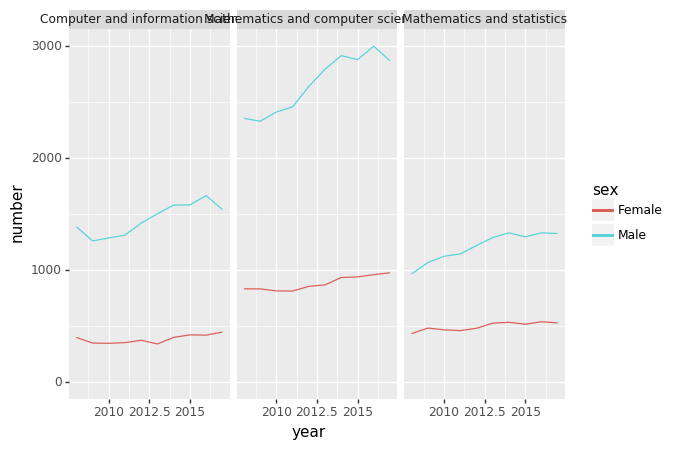

<ggplot: (294099320)>

In [9]:
(
    recipients_year_field_sex
    >> filter(_.sex != "All", _.broad_field == "Mathematics and computer sciences")
    >> ggplot(aes("year", "number", color="sex"))
    + geom_line()
    + expand_limits(y=0)
    + facet_wrap("~ field")
)

In [10]:
from siuba.dply.forcats import fct_reorder


example = (    
    recipients_year_field_sex
    >> spread(_.sex, _.number)
    >> mutate(pct_male=_.Male / _.All)
    >> filter(_.broad_field == "Engineering")
)

fct_reorder(example.field, -example.pct_male)

[Aerospace, aeronautical, and astronautical eng..., Aerospace, aeronautical, and astronautical eng..., Aerospace, aeronautical, and astronautical eng..., Aerospace, aeronautical, and astronautical eng..., Aerospace, aeronautical, and astronautical eng..., ..., Other engineering, Other engineering, Other engineering, Other engineering, Other engineering]
Length: 100
Categories (10, object): [Mechanical engineering, Aerospace, aeronautical, and astronautical eng..., Electrical, electronics, and communications en..., Other engineering, ..., Materials science engineering, Industrial and manufacturing engineering, Chemical engineering, Bioengineering and biomedical engineering]

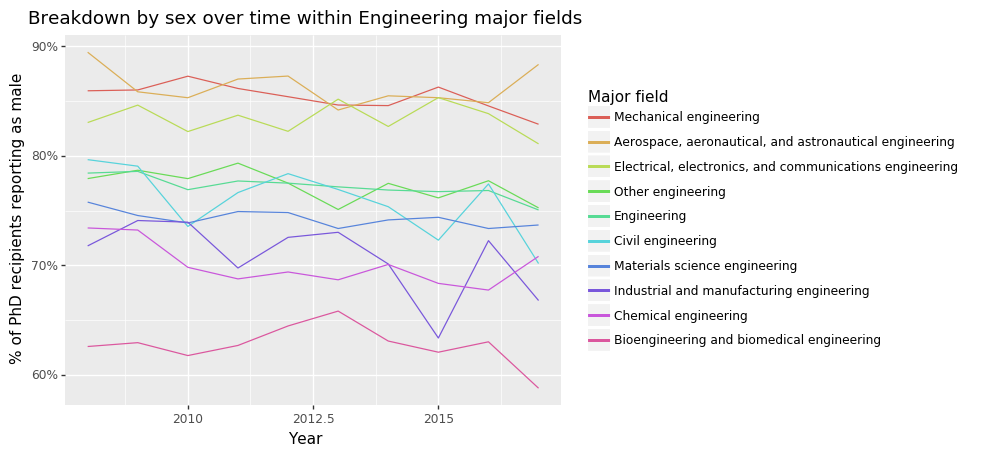

<ggplot: (-9223372036558113206)>

In [11]:
(
    recipients_year_field_sex
    >> spread(_.sex, _.number)
    >> mutate(pct_male=_.Male / _.All)
    >> filter(_.broad_field == "Engineering")
    >> mutate(field = fct_reorder(_.field, -_.pct_male))
    >> ggplot(aes("year", "pct_male", color="field"))
    + geom_line()
    + scale_y_continuous(labels=lambda l: ["{:.0f}%".format(v * 100) for v in l])
    + labs(
        x="Year",
        y="% of PhD recipients reporting as male",
        color="Major field",
        title="Breakdown by sex over time within Engineering major fields",
    )
)

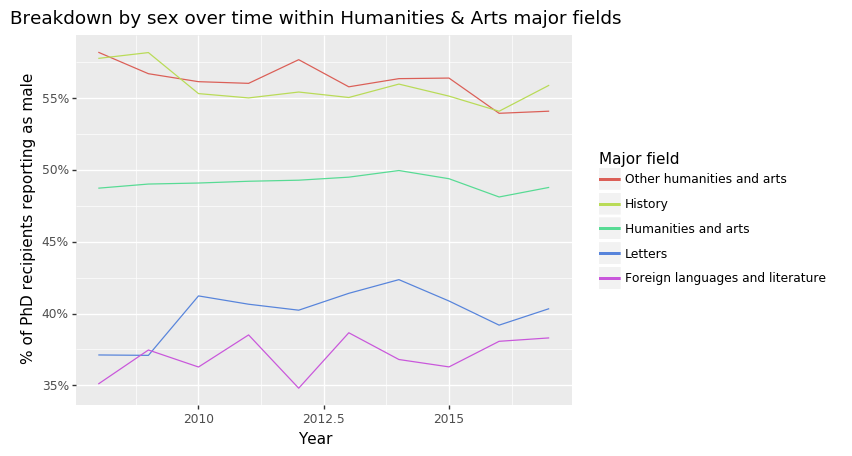

<ggplot: (296662108)>

In [12]:
(
    recipients_year_field_sex
    >> spread(_.sex, _.number)
    >> mutate(pct_male=_.Male / _.All)
    >> filter(_.broad_field == "Humanities and arts")
    >> mutate(field = fct_reorder(_.field, -_.pct_male))
    >> ggplot(aes("year", "pct_male", color="field"))
    + geom_line()
    + scale_y_continuous(labels=lambda l: ["{:.0f}%".format(v * 100) for v in l])
    + labs(
        x="Year",
        y="% of PhD recipients reporting as male",
        color="Major field",
        title="Breakdown by sex over time within Humanities & Arts major fields",
    )
)

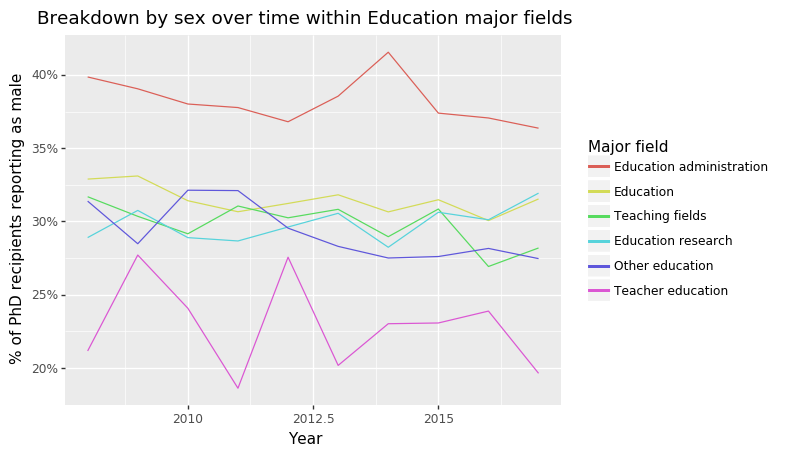

<ggplot: (296903558)>

In [13]:
(
    recipients_year_field_sex
    >> spread(_.sex, _.number)
    >> mutate(pct_male=_.Male / _.All)
    >> filter(_.broad_field == "Education")
    >> mutate(field = fct_reorder(_.field, -_.pct_male))
    >> ggplot(aes("year", "pct_male", color="field"))
    + geom_line()
    + scale_y_continuous(labels=lambda l: ["{:.0f}%".format(v * 100) for v in l])
    + labs(
        x="Year",
        y="% of PhD recipients reporting as male",
        color="Major field",
        title="Breakdown by sex over time within Education major fields",
    )
)

# Include code for tabs

In [14]:
def javascript(*st,file=None):
    from IPython.display import display, HTML
    if len(st) == 1 and file is None:
        s = st[0]
    elif len(st) == 0 and file is not None:
        s = open(file).read()
    else:
        raise ValueError('Pass either a string or file=.')
    display(HTML("<script type='text/javascript'>" + s + "</script>"))
    
javascript(file = "templates/puretabs.js")

In [15]:
%%html
<script>
  window.onload = function() {
    //pureTabs.init();
    //pureTabs.init('tabs', 'tabs--active');
    pureTabs.init('pytabs-1', 'tabs__link--active');
    pureTabs.init('pytabs-2', 'tabs__link--active');      
    pureTabs.init('pytabs-2', 'tabs__link--active');      
    pureTabs.init('pytabs-3', 'tabs__link--active');      
    pureTabs.init('pytabs-4', 'tabs__link--active');      
    pureTabs.init('pytabs-5', 'tabs__link--active');      
    pureTabs.init('pytabs-6', 'tabs__link--active');      
    pureTabs.init('pytabs-7', 'tabs__link--active');      
    pureTabs.init('pytabs-8', 'tabs__link--active');      
    pureTabs.init('pytabs-9', 'tabs__link--active');      
    pureTabs.init('pytabs-10', 'tabs__link--active');      
    pureTabs.init('pytabs-11', 'tabs__link--active');      

  }
</script>
